In [1]:
# Instalación de paquetes necesarios
!pip3 install sentencepiece
!pip3 install pytorch-lightning
!pip3 install --upgrade accelerate
!pip3 install emoji
!pip3 install framework-reproducibility
!pip3 install transformers
!pip3 install sacremoses # for data augmentation by back-translation
!pip3 install -U easynmt # for data augmentation by back-translation
!pip3 install transformers datasets
!pip3 install contractions
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install sklearn-hierarchical-classification # para ejecutar subtask_1_2a.py
!pip3 install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 881.8 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1


In [2]:
# Importar librerías
import json
import csv
import random
import torch
import numpy as np
import os
import string # remove punctuations
import re # remove punctuations
import contractions # convert abbreviations to their complete forms
import tensorflow as tf
import fwr13y.d9m.tensorflow as tf_determinism
from pytorch_lightning import seed_everything
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer # to one-hot-encode the label columns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, EarlyStoppingCallback
from transformers import set_seed, enable_full_determinism

# Para garantizar la reproducibilidad de nuestros experimentos
# Establecer el determinismo
tf_determinism.enable_determinism()
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)# Store the average loss after eachepoch so we can plot them.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["TF_DETERMINISTIC_OPS"] = "1" # See:https://github.com/NVIDIA/tensorflow-determinism#confirmed-current-gpu-specific-sources-of-non-determinism-with-solutions
set_seed(seed_val)
enable_full_determinism(seed_val)
seed_everything(seed_val, workers=True)

# set default plot colors
# plt.style.use('default')
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'

# set up root path
root_path = os.getcwd()

# path to the datasets
data_path = f'{root_path}/data/'

# path to save figures
save_path = f'{root_path}/figures/'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.16.1


# Carga de datos

In [3]:
def read_json_as_df(json_path):
  """
  Read a json file and returns it as a pandas.DataFrame with the id field in the json file being set as the index of the dataframe

  Args:
    json_path (str): Absolute path to the json file

  Returns:
    df (pd.DataFrame): the json file read as pd.DataFrame
  """
  df = pd.read_json(json_path) # note that the label column is saved literally as list in the dataframe entries
  df.set_index('id',drop=True,inplace=True)
  return df

def one_hot_encode_df(df):
  """
  Takes the dataframe parsed from json files and one-hot-encode the labels column. Note: data with empty list as labels are retained in the one-hot-encoded dataframe

  Args:
    df (pd.DataFrame): DataFrame parsed from json file

  Returns:
    df (pd.DataFrame): DataFrame with the labels column one-hot-encoded
  """
  mlb = MultiLabelBinarizer()
  df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labels')),columns=mlb.classes_,index=df.index))
  return df

In [4]:
train_df = read_json_as_df(f"{data_path}semeval2024_dev_release/subtask1/train.json")
validation_df = read_json_as_df(f"{data_path}semeval2024_dev_release/subtask1/validation.json")
# the dev set in semeval2024_dev_release does not contain label while that in dev_gold_labels does, both contain the same data, so I will read in only the one from dev_gold_labels
dev_df = read_json_as_df(f"{data_path}dev_gold_labels/dev_subtask1_en.json")

print('Dataframes read in from the json files:')
print(f'train df shape: {train_df.shape}\nvalidation df shape: {validation_df.shape}\ndevelopment df shape: {dev_df.shape}\n')

# One-hot-encoding the 'labels' columns of the three dfs
train_df = one_hot_encode_df(train_df)
validation_df = one_hot_encode_df(validation_df)
dev_df = one_hot_encode_df(dev_df)

print('One-hot-encoded dataframes:')
print(f'train df shape: {train_df.shape}\nvalidation df shape: {validation_df.shape}\ndevelopment df shape: {dev_df.shape}')

Dataframes read in from the json files:
train df shape: (7000, 3)
validation df shape: (500, 3)
development df shape: (1000, 3)

One-hot-encoded dataframes:
train df shape: (7000, 22)
validation df shape: (500, 22)
development df shape: (1000, 22)


## Mostrar la division de datos con un piechart

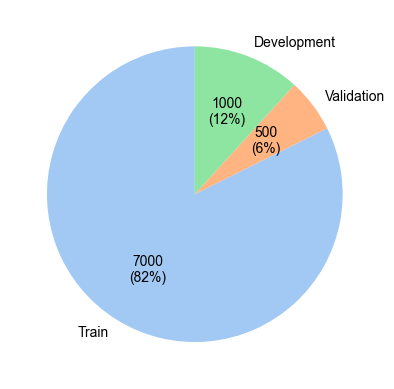

In [5]:
# Data to plot
piechart_labels = ['Train','Validation','Development']
sizes = [7000,500,1000]

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=piechart_labels, colors=sns.color_palette('pastel'), autopct=lambda pct: f'{int(pct/100.*sum(sizes))}\n({pct:.0f}%)', startangle=90)

plt.savefig(f'{save_path}data_analysis/datasets_piechart.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/datasets_piechart.png',bbox_inches='tight',transparent=True,dpi=300)
plt.show()


In [6]:
# hagamos una cuenta de los datos disponibles en las tablas
labels = dev_df.columns[2:]

print(f'Train df:')
print(train_df[labels].sum())
print(f'\nValidation df:')
print(validation_df[labels].sum())
print(f'\nDev df:')
print(dev_df[labels].sum())

Train df:
Appeal to authority                                     850
Appeal to fear/prejudice                                337
Bandwagon                                                97
Black-and-white Fallacy/Dictatorship                    780
Causal Oversimplification                               240
Doubt                                                   350
Exaggeration/Minimisation                               356
Flag-waving                                             571
Glittering generalities (Virtue)                        488
Loaded Language                                        1750
Misrepresentation of Someone's Position (Straw Man)      62
Name calling/Labeling                                  1518
Obfuscation, Intentional vagueness, Confusion            21
Presenting Irrelevant Data (Red Herring)                 59
Reductio ad hitlerum                                     63
Repetition                                              305
Slogans                       

## Visualizar los numeros y las proporciones de etiqueta en cada dataset

In [7]:
# concatenate all datasets together for easier manipulation later
train_df['data_type'] = 'Train'
validation_df['data_type'] = 'Validation'
dev_df['data_type'] = 'Development'
temp = pd.concat([pd.concat([train_df,validation_df],axis=0),dev_df],axis=0)

# remove the 'data_type' column from the datasets to not affect the downstream work
for df in [train_df,validation_df,dev_df]:
    df.drop(columns=['data_type'],inplace=True)

temp = temp.melt(id_vars=['data_type'],value_vars=labels)
temp = temp[temp['value']!= 0].reset_index(drop=True).rename({'variable':'Labels'},axis=1)

In [8]:
# count the total number of labels in each dataset for normalization later
data_type_label_count = temp.groupby('data_type').agg({'value':'sum'})
data_type_label_count = dict(zip(data_type_label_count.index, data_type_label_count['value'].values))

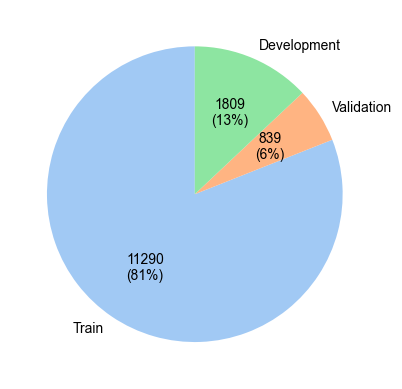

In [9]:
# Data to plot
piechart_labels = ['Train','Validation','Development']
sizes = [data_type_label_count.get(l) for l in piechart_labels]

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=piechart_labels, colors=sns.color_palette('pastel'), autopct=lambda pct: f'{int(pct/100.*sum(sizes))}\n({pct:.0f}%)', startangle=90)

plt.savefig(f'{save_path}data_analysis/datasets_labels_piechart.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/datasets_labels_piechart.png',bbox_inches='tight',transparent=True,dpi=300)
plt.show()


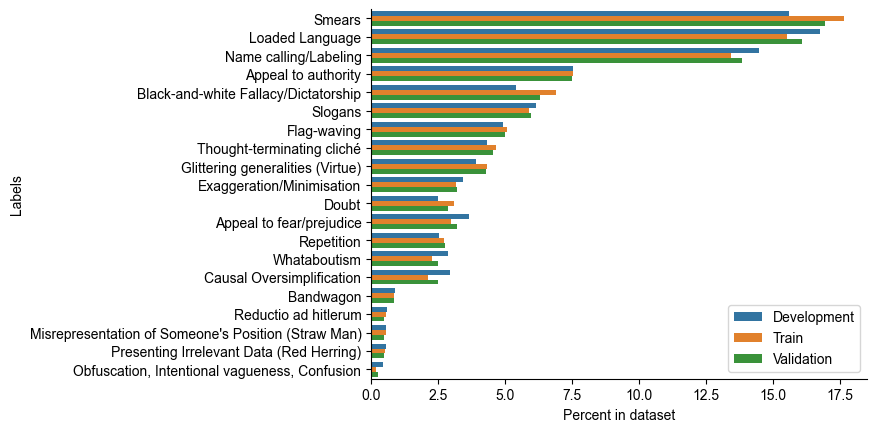

In [10]:
# count the number of the individual label in each dataset
temp = temp.groupby(['data_type','Labels']).size().reset_index().rename({0:'count'},axis=1)

# append information of the total number of labels in each dataset for normalization
temp['total_label_per_data_type'] = [data_type_label_count.get(data_type) for data_type in temp['data_type']]

# perform normalization of the label counts based on available data in each dataset
temp['norm_label_count'] = temp['count'] / temp['total_label_per_data_type']
temp['percent_label_count'] = temp['norm_label_count'] * 100

# order the bars on the barplot by sorting the data based on available data per label in the training dataset
order = temp[temp['data_type'] == 'Train'].sort_values(['percent_label_count'],ascending=False)['Labels'].to_list()

# sns.set_palette(palette=sns.color_palette())
fig, ax = plt.subplots()
bar = sns.barplot(data=temp, x='percent_label_count', y='Labels',orient='h',hue='data_type',order=order, ax=ax)

ax.set_xlabel('Percent in dataset')
ax.legend()

plt.savefig(f'{save_path}data_analysis/percent_labels_in_dataset.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/percent_labels_in_dataset.png',bbox_inches='tight',dpi=300)

# Limpieza de datos
Cosas para quitar:
- linebreaks, como \n, \r
- convertir contracciones a su forma completa, como we're a we are
- punctuaciones
- todo en minusculas
- enlace
- usuario como @tweeter_user
- hashtags
- VIDEOs o AUDIOS

In [11]:
# Funciones de limpieza
def remove_linebreaks(s): # s to avoid the word string
  """
  Removes linebreaks such as /n and /r in a string.

  Args:
    s (str): Input string

  Returns:
    s (str): Modified string
  """
  s = re.sub(r'\\n','\n',s) # some lines have '\\n', not sure why but best to covert them to '\n' for later processing, see dev_df.loc[75006].text
  return ' '.join(s.split())

def remove_links(s):
    """Takes a string and removes web links from it"""
    s = re.sub(r'http\S+', '', s)   # remove http links
    s = re.sub(r'bit.ly/\S+', '', s)  # remove bitly links
    s = re.sub(r'\[link\]', '', s )   # remove [link]
    s = re.sub(r'\[url\]', '', s )   # remove [url]
    s = re.sub(r'pic.twitter\S+','', s)
    return s

def remove_users(s):
    """Takes a string and removes res and @user information"""
    s = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove re-s
    s = re.sub(r'(@[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove sed at
    s = re.sub(r'\[user\]', '', s )   # remove [user]
    return s

def remove_hashtags(s):
    """Takes a string and removes any hash tags"""
    s = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove hash tags
    return s

def remove_av(s):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    s = re.sub('VIDEO:', '', s)  # remove 'VIDEO:' from start of s
    s = re.sub('AUDIO:', '', s)  # remove 'AUDIO:' from start of s
    return s

def remove_emojis(s):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00010000-\U0010FFFF"
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\ufe0f"  # dingbats

                      "]+", re.UNICODE)
    return re.sub(emoj, '', s)

def remove_punctuations(s): # s to avoid the word string
  """
  Remove punctuations in a string

  Args:
    s (str): Input string

  Returns:
    s (str): Modified string
  """
  regex = re.compile('[%s]' % re.escape(string.punctuation))
  return regex.sub('', s)

# Función de eliminación de contracción
def expand_contraction(s):
    s = contractions.fix(s)
    return s

def process_text(s):
  """
  Wraps the functions together to clean strings and finally converts everything to lower case

  Args:
    s (str): Input string

  Returns:
    s(str): Modified string
  """
  s = remove_linebreaks(s)
  s = remove_links(s)
  s = remove_users(s)
  s = remove_hashtags(s)
  s = remove_av(s)
  s = remove_emojis(s)
  s = remove_punctuations(s)
  s = expand_contraction(s)
  return s.lower()

def process_text_keep_punc(s):
  """
  Wraps the functions together to clean strings and finally converts everything to lower case

  Args:
    s (str): Input string

  Returns:
    s(str): Modified string
  """
  s = remove_linebreaks(s)
  s = remove_links(s)
  s = remove_users(s)
  s = remove_hashtags(s)
  s = remove_av(s)
  s = remove_emojis(s)
  # s = remove_punctuations(s)
  s = expand_contraction(s)
  return s.lower()

test = '''\This is why we're free\n\nThis is why!'''
print(process_text(test))
print(process_text_keep_punc(test))

this is why were free this is why
\this is why we are free this is why!


<>:124: SyntaxWarning: invalid escape sequence '\T'
<>:124: SyntaxWarning: invalid escape sequence '\T'
/var/folders/3r/f1l4vn9511q3qgj0z6f88d140000gn/T/ipykernel_38241/3974775476.py:124: SyntaxWarning: invalid escape sequence '\T'
  test = '''\This is why we're free\n\nThis is why!'''


In [12]:
train_with_punc_df = train_df.copy()
train_with_punc_df['processed_text'] = train_df['text'].apply(lambda x: process_text_keep_punc(x))

In [13]:
train_df['processed_text'] = train_df['text'].apply(lambda x: process_text(x))
validation_df['processed_text'] = validation_df['text'].apply(lambda x: process_text(x))
dev_df['processed_text'] = dev_df['text'].apply(lambda x: process_text(x))

In [14]:
train_df

,text,link,Appeal to authority,Appeal to fear/prejudice,Bandwagon,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Doubt,Exaggeration/Minimisation,Flag-waving,...,Name calling/Labeling,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),Reductio ad hitlerum,Repetition,Slogans,Smears,Thought-terminating cliché,Whataboutism,processed_text
id,,,,,,,,,,,,,,,,,,,,,
65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,https://www.facebook.com/photo/?fbid=402355213...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,this is why you need a sharpie with you at all...
67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good news nazanin zaghariratcliffe and anooshe...
68031,PAING PHYO MIN IS FREE!,https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,paing phyo min is free
77490,Move your ships away!\n\noooook\n\nMove your s...,https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,move your ships away oooook move your ships aw...
67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,when you are the fbi they let you do it
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67360,If your doctor prescribes you medication witho...,https://www.facebook.com/TheControversia/photo...,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,if your doctor prescribes you medication witho...
70579,DEFENDS TRUMP. \nMADE ALLEGATIONS OF ELECTION ...,https://www.facebook.com/PatriotFetch/photos/p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,defends trump made allegations of election fra...
70305,I'm having trouble selling our incredibly enor...,https://www.facebook.com/PatriotFetch/photos/p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i am having trouble selling our incredibly eno...


In [15]:
train_df[train_df['processed_text'] == '']

,text,link,Appeal to authority,Appeal to fear/prejudice,Bandwagon,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Doubt,Exaggeration/Minimisation,Flag-waving,...,Name calling/Labeling,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),Reductio ad hitlerum,Repetition,Slogans,Smears,Thought-terminating cliché,Whataboutism,processed_text
id,,,,,,,,,,,,,,,,,,,,,
64922,#GODWINS,https://www.facebook.com/photo/?fbid=488289762...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,
68048,#FREEKILWE,https://www.facebook.com/amnesty/photos/410138...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,
65550,,https://www.facebook.com/photo/?fbid=521292664...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,
66888,#AleppolsBurning\n,null,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,
77411,#BendTheWall,https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,
65742,#crimeanbridge,https://www.facebook.com/photo/?fbid=465584008...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,


Found some datapoints in train_df that has no processed_text because they are hastags, I will remove them since without processed_text they can't help to fine-tune LLM.

In [16]:
print(train_df.shape)
train_df.drop(index=train_df[train_df['processed_text'] == ''].index, inplace=True)
print(train_df.shape)

print(train_with_punc_df.shape)
train_with_punc_df.drop(index=train_with_punc_df[train_with_punc_df['processed_text'] == ''].index, inplace=True)
print(train_with_punc_df.shape)

(7000, 23)
(6994, 23)
(7000, 23)
(6994, 23)


## Solo en train dataset: Visualizar las cantidades de palabras en cada etiqueta, para saber si existen algunas etiquetas que tienen mas palabras (informaciones) que las otras etiquetas

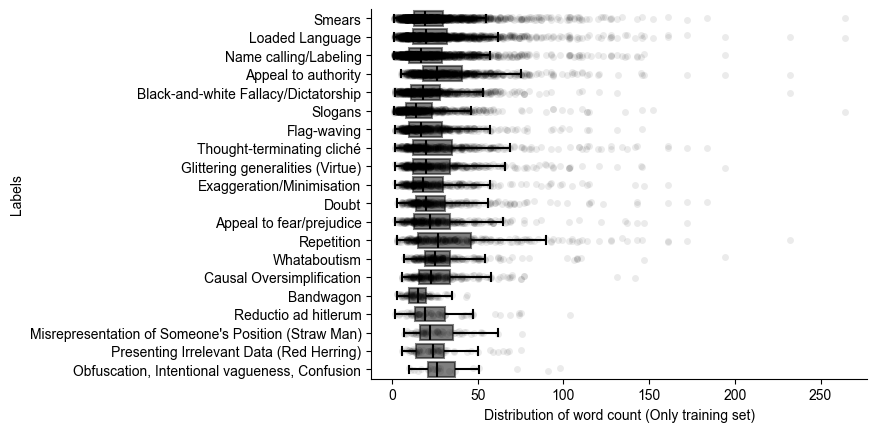

In [17]:
temp = train_df.copy()
temp['word_count'] = [len(text.split()) for text in temp['processed_text']]
temp = temp.melt(id_vars='word_count', value_vars=labels)
temp = temp[temp['value'] != 0].reset_index(drop=True)

fig, ax = plt.subplots()

box = sns.boxplot(data=temp,x='word_count',y='variable',orient='h',order=order,linewidth=1.5,showfliers=False,boxprops={'alpha':0.5},color='black',ax=ax)
strip = sns.stripplot(data=temp,x='word_count',y='variable',orient='h',order=order,alpha=0.08,color='black',ax=ax)

ax.set_ylabel('Labels')
ax.set_xlabel('Distribution of word count (Only training set)')

plt.savefig(f'{save_path}data_analysis/boxplot_word_count_per_label.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/boxplot_word_count_per_label.png',bbox_inches='tight',dpi=300)

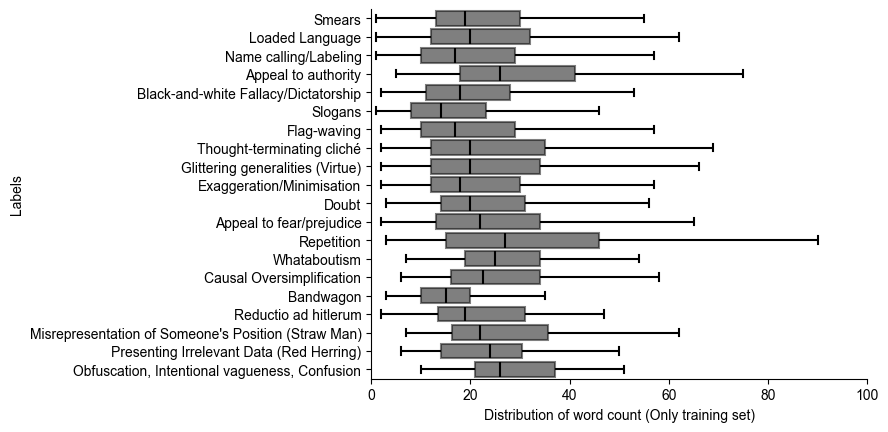

In [18]:
# plot the same but without the outliers
fig, ax = plt.subplots()

box = sns.boxplot(data=temp,x='word_count',y='variable',orient='h',order=order,linewidth=1.5,showfliers=False,boxprops={'alpha':0.5},color='black',ax=ax)

ax.set_ylabel('Labels')
ax.set_xlabel('Distribution of word count (Only training set)')
ax.set_xlim([0,100])
# ax.set_xscale('log')

plt.savefig(f'{save_path}data_analysis/boxplot_word_count_per_label_no_outlier.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/boxplot_word_count_per_label_no_outlier.png',bbox_inches='tight',dpi=300)

## Visualizar las correlaciones entre etiquetas

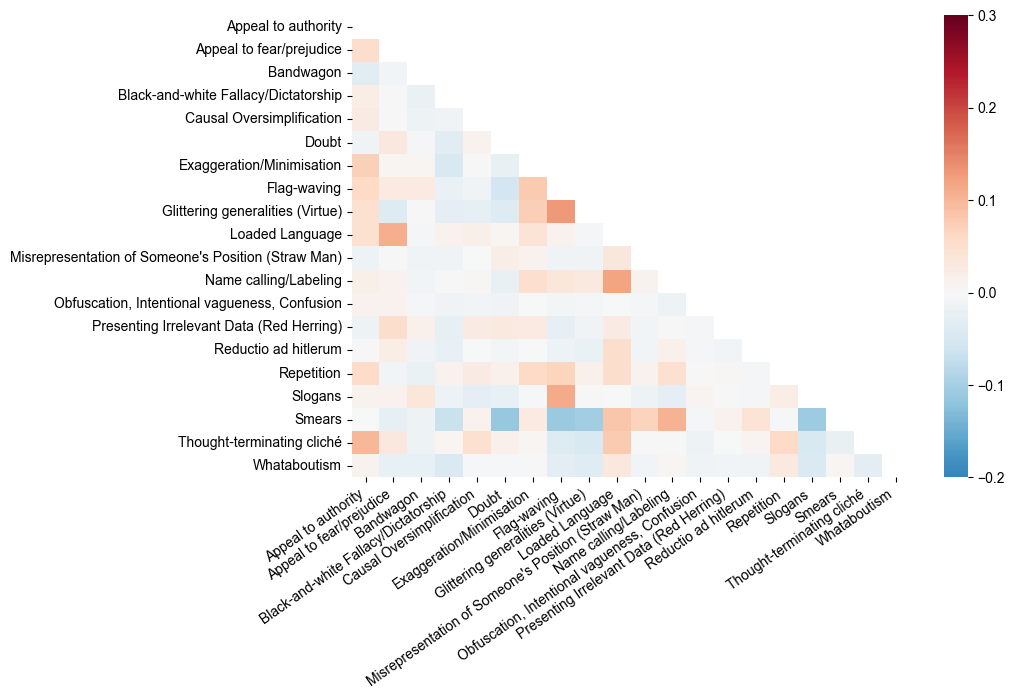

In [19]:
# draw the lower triangle correlation matrix of the labels
temp = train_df[labels].corr()

# Create a mask
mask = np.triu(np.ones_like(temp, dtype=bool))

fig, ax = plt.subplots(figsize=(9,6))

heatmap = sns.heatmap(data=temp,mask=mask,cmap='RdBu_r',center=0,vmin=-0.2,vmax=0.3,ax=ax)

plt.xticks(rotation=35, ha='right')

plt.savefig(f'{save_path}data_analysis/training_set_labels_correlation.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/training_set_labels_correlation.png',bbox_inches='tight',dpi=300)

# Aumentacion y subsampling de datos para balancear el numero de datos en las etiquetas

### Exportar la tabla de train_df con columna processed_text para que se pueda ejecutar el escript de data_downsampling_augmentation.py con ella

In [20]:
train_df.to_csv(f'{data_path}preprocessed_datasets/train_df.csv')

In [21]:
# read in the balanced_train_df that was previously generated through data augmentation and downsampling
balanced_train_df = pd.read_csv(f'{data_path}preprocessed_datasets/600_balanced_train_df.csv',index_col=0)
balanced_train_df.index.names = train_df.index.names
balanced_train_df

,text,link,Appeal to authority,Appeal to fear/prejudice,Bandwagon,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Doubt,Exaggeration/Minimisation,Flag-waving,...,Name calling/Labeling,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),Reductio ad hitlerum,Repetition,Slogans,Smears,Thought-terminating cliché,Whataboutism,processed_text
id,,,,,,,,,,,,,,,,,,,,,
63902,IT'S BEGINNING TO LOOK A LOT LIKE I TOLD YOU SO,https://www.facebook.com/photo/?fbid=159772019...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,its beginning to look a lot like i told you so
64429,BELIEVE IN YOURSELF.\nEVEN IF IT MEANS RIDING ...,https://www.facebook.com/photo.php?fbid=304649...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,believe in yourself even if it means riding on...
70706,\COVID has taken this year - just since the ou...,NaN,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,covid has taken this year just since the outb...
63895,Fox News just asked what he'd do differently f...,https://www.facebook.com/photo/?fbid=133469339...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,fox news just asked what he would do different...
68900,"UNDER MY PLAN, IF A WHEEL FALLS OFF THE CANOE ...",https://www.facebook.com/Extortion17DemandaCon...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,under my plan if a wheel falls off the canoe y...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77045,There's a storm coming.\nUnlike any storm you'...,https://www.facebook.com/rightpatriots/photos/...,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,there is a storm coming unlike any storm you h...
66735,STOP POSTING STUFF\n\nIT DOESN'T FIT MY REALIT...,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,stop posting stuff it does not fit my reality ...
64340,ONLY YOU CAN PREVENT WILDFIRES!\nRecall Gavin ...,https://www.facebook.com/photo/?fbid=102188056...,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,only you can prevent wildfires recall gavin ne...


In [22]:
print(balanced_train_df[labels].sum())

Appeal to authority                                     664
Appeal to fear/prejudice                                725
Bandwagon                                               643
Black-and-white Fallacy/Dictatorship                    600
Causal Oversimplification                               720
Doubt                                                   670
Exaggeration/Minimisation                               726
Flag-waving                                             665
Glittering generalities (Virtue)                        708
Loaded Language                                        1201
Misrepresentation of Someone's Position (Straw Man)     632
Name calling/Labeling                                   950
Obfuscation, Intentional vagueness, Confusion           608
Presenting Irrelevant Data (Red Herring)                642
Reductio ad hitlerum                                    627
Repetition                                              793
Slogans                                 

La etiqueta 'Loaded language' tiene correlaciones (debiles) con muchas otras etiquetas, creo que es por eso es dificil balancearla.

Revisualizar las proporciones de datos en cada etiqueta

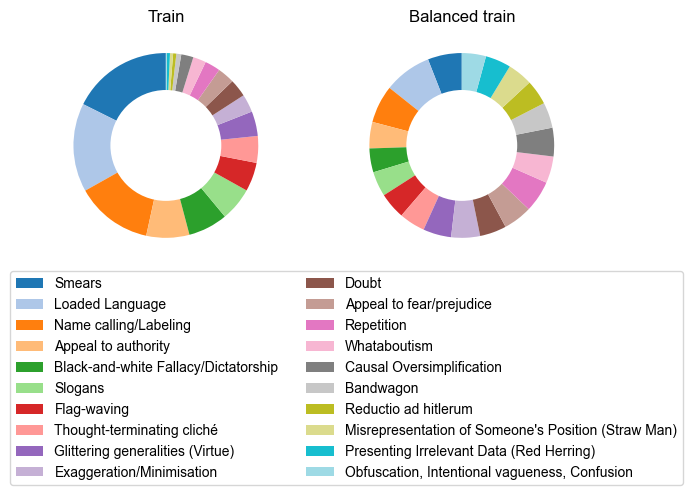

In [23]:
train_label_dict = dict(train_df[labels].sum().sort_values(ascending=False))
balanced_train_label_dict = dict(balanced_train_df[labels].sum())
# ensure that the balanced_train_label_dict has the same order as train_label_dict
balanced_train_label_dict = {label: balanced_train_label_dict.get(label) for label in train_label_dict}
colors = plt.cm.tab20.colors

# Plotting the donut chart with legend instead of direct labels
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(7,3))

for ax, label_dict, label in zip([ax1,ax2],[train_label_dict,balanced_train_label_dict],['Train','Balanced train']):
    wedges, texts = ax.pie(label_dict.values(), colors=colors, startangle=90, pctdistance=0.85)
    # Draw circle
    centre_circle = plt.Circle((0, 0), 0.60, fc='white')
    ax.set_title(label)
    ax.add_artist(centre_circle)

plt.legend(wedges, train_label_dict.keys(), loc="lower center", bbox_to_anchor=(0,-1.0),ncol=2)

plt.savefig(f'{save_path}data_analysis/train_balanced_train_proportion.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/train_balanced_train_proportion.png',bbox_inches='tight',dpi=300)

Revisualizar las correlaciones entre etiquetas para ver si la aumentacion o downsampling cambia las correlaciones.

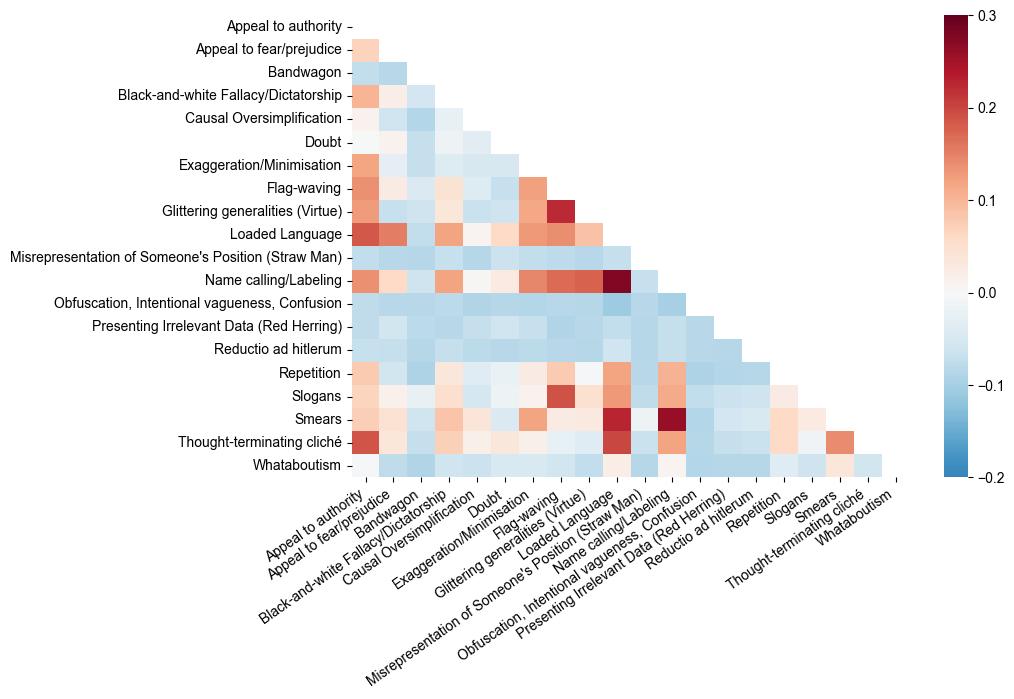

In [24]:
# draw the lower triangle correlation matrix of the labels
temp = balanced_train_df[labels].corr()

# Create a mask
mask = np.triu(np.ones_like(temp, dtype=bool))

fig, ax = plt.subplots(figsize=(9,6))

heatmap = sns.heatmap(data=temp,mask=mask,cmap='RdBu_r',center=0,vmin=-0.2,vmax=0.3,ax=ax) # vmin and vmax selected after checking the plot generated without specifying anything
# vmin and vmax selected to be the same as the correlation heatmap of train_df to make the color scale uniform between the plots for comparison

plt.xticks(rotation=35, ha='right')

plt.savefig(f'{save_path}data_analysis/balanced_training_set_labels_correlation.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}data_analysis/balanced_training_set_labels_correlation.png',bbox_inches='tight',dpi=300)

Las etiquetas siguen teniendo pocas correlaciones, aunque sean mas fuertes que las de train_df, el queno ha sido aumentado o downsampling.

In [25]:
order

['Smears',
 'Loaded Language',
 'Name calling/Labeling',
 'Appeal to authority',
 'Black-and-white Fallacy/Dictatorship',
 'Slogans',
 'Flag-waving',
 'Thought-terminating cliché',
 'Glittering generalities (Virtue)',
 'Exaggeration/Minimisation',
 'Doubt',
 'Appeal to fear/prejudice',
 'Repetition',
 'Whataboutism',
 'Causal Oversimplification',
 'Bandwagon',
 'Reductio ad hitlerum',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Presenting Irrelevant Data (Red Herring)',
 'Obfuscation, Intentional vagueness, Confusion']

In [43]:
# hagamos una cuenta de los datos disponibles en las tablas
labels = dev_df.columns[2:-1]

train_count = dict(zip(train_df[labels].sum().index,train_df[labels].sum().values))
balanced_train_count = dict(zip(balanced_train_df[labels].sum().index,balanced_train_df[labels].sum().values))
dev_count = dict(zip(dev_df[labels].sum().index,dev_df[labels].sum().values))

count_df = pd.DataFrame(columns=['Labels','Original training set','Balanced training set', 'Development set'])
count_df['Labels'] = train_count.keys()
count_df['Original training set'] = train_count.values()
count_df['Balanced training set'] = balanced_train_count.values()
count_df['Development set'] = dev_count.values()
# add a total row at the bottom
total_index = len(count_df)
count_df.loc[total_index,'Labels'] = 'Total'
count_df.loc[total_index,'Original training set'] = sum(train_count.values())
count_df.loc[total_index,'Balanced training set'] = sum(balanced_train_count.values())
count_df.loc[total_index,'Development set'] = sum(dev_count.values())
count_df['Original training set'] = count_df['Original training set'].astype('int')
count_df['Balanced training set'] = count_df['Balanced training set'].astype('int')
count_df['Development set'] = count_df['Development set'].astype('int')
count_df

,Labels,Original training set,Balanced training set,Development set
0,Appeal to authority,850,664,136
1,Appeal to fear/prejudice,337,725,66
2,Bandwagon,97,643,16
3,Black-and-white Fallacy/Dictatorship,780,600,98
4,Causal Oversimplification,240,720,53
5,Doubt,350,670,45
6,Exaggeration/Minimisation,356,726,62
7,Flag-waving,571,665,89
8,Glittering generalities (Virtue),488,708,71
9,Loaded Language,1750,1201,303


In [54]:
for i, ele in train_df[train_df['Appeal to authority'] == 1].processed_text.items():
    print(i, ele)

71251 heaven has a wall and strict immigration policies hell has open borders president donald j trump
68239 never forget attacks on the working class come from those who travel by private jet not migrant dinghy  zarah sultana
76179 anyone can make war but only the most courageous can make peace  president donald j trump
64740 donald trump must be indicted a failure to prosecute trump for his conspiracy to overthrow our democracy guarantees future attempts to overthrow our democracy glenn kirschner
65509 dear america you are waking up as germany once did to the awareness that 13 of your people would kill another 13 while 13 watches werner herzog
63501 socialism is all about control control control dave robbins
64802 every staff member has to take an ethics training every year to remind them what is in and out of bounds i do not mean to make light of it but just for the record and for those watching at home trying to overturn an election is out of bounds january 6 committee chair bennie

In [53]:
for i, ele in train_df[train_df['Obfuscation, Intentional vagueness, Confusion'] == 1]['processed_text'].items():
    print(i, ele)

63902 its beginning to look a lot like i told you so
64429 believe in yourself even if it means riding on the edge of a lightning bolt in the danger z0ne of the kingdom or madness just dig it
70706 covid has taken this year  just since the outbreakhas taken more than 100 yearlook here is the lives its just its just i mean think about it  more lives this year than any other year joe biden
63895 fox news just asked what he would do differently from biden on ukraine well what i would do is i would we would we have tremendous military capability and what we can do without planes to be honest with you without 44yearold jets what we can do is enormous and we should be doing it and we should be helping them to survive and they are doing an amazing job donald j trump
68900 under my plan if a wheel falls off the canoe your dog house will be filled with pancakes i am joe biden and i am running for senate
66787 in 20000 years chernobyl will be safe again for humans fukushima will eventually conta

# Exportar los dataframes preprocesado para utilizarlos en model fine-tuning.

In [26]:
train_with_punc_df.to_csv(f'{data_path}preprocessed_datasets/train_with_punc_df.csv')
train_df.to_csv(f'{data_path}preprocessed_datasets/train_df.csv')
validation_df.to_csv(f'{data_path}preprocessed_datasets/validation_df.csv')
dev_df.to_csv(f'{data_path}preprocessed_datasets/dev_df.csv')

# Preprocesar el test data para exportarlo tambien

In [27]:
test_df = read_json_as_df(f"{data_path}scorer-baseline/english/en_subtask1_test_majority_smears.txt")
test_df['processed_text'] = test_df['text'].apply(lambda x: process_text(x))
test_df.to_csv(f'{data_path}preprocessed_datasets/test_df.csv')